In [4]:
# Weight-State FLOPS Ratio (WSFR) Analysis
# This notebook analyzes the computational complexity of different attention mechanisms
# by comparing weight-based operations vs state-based operations

import pandas
import matplotlib
import math
from typing import Callable, Optional
from dataclasses import dataclass
from abc import ABC, abstractmethod
import logging
from vidrial.mosaic.utils.common import default_d_tile
from vidrial.kernels.sympow_mma.dimensions import sympow_dim
import pandas as pd

logger = logging.getLogger(__name__)
# Helper function to compute default dimension for power retention
# This calculates the expanded dimension D based on the attention head dimension and polynomial degree
def default_D(d, deg):
    return sympow_dim(d, deg, d_tile=default_d_tile(d, deg))

# Problem specification: defines the computational workload
@dataclass
class Problem:
    b: int = 8      # Batch size
    t: int = 1024   # Sequence length (context length)

# Abstract base class for model components
# Each component must define its computational complexity (FLOPS) and memory requirements (state size)
@dataclass
class Component(ABC):
    @abstractmethod
    def state_flops(self, problem: Problem) -> float:
        """Calculate state-based floating point operations for this component given a problem"""
        pass

    @abstractmethod
    def weight_flops(self, problem: Problem) -> float:
        """Calculate weight-based floating point operations for this component given a problem"""
        pass

    @abstractmethod
    def state_size(self, problem: Problem) -> int:
        """Calculate memory state size required for this component"""
        pass

# Multi-Layer Perceptron (Feed-Forward Network)
# This represents the weight-based computation in transformer models
@dataclass
class MLP(Component):
    intermediate_size: int  # Hidden dimension of the FFN (typically 4x hidden_size)
    hidden_size: int       # Model hidden dimension
    window_size: Optional[int] = None
    
    def state_flops(self, problem: Problem):
        return 0
    
    def weight_flops(self, problem: Problem):
        # FLOPS = 2 layers * 2 ops (fwd+bwd) * weight_matrix_size * batch * sequence
        # Two linear transformations: hidden -> intermediate -> hidden
        if self.window_size is None:
            return 2 * 2 * self.intermediate_size * self.hidden_size * problem.b * problem.t
        else:
            return 2 * 2 * self.intermediate_size * self.hidden_size * problem.b * self.window_size
        
    def state_size(self, problem: Problem):
        # MLPs are stateless - no recurrent memory required
        return 0

@dataclass
class Attention(Component):
    h: int
    d: int
    hidden_size: Optional[int] = None
    def state_flops(self, problem: Problem):
        return self.h * (2 * problem.t * problem.t * self.d / 2 + 2 * problem.t * self.d * problem.t)
    
    def weight_flops(self, problem: Problem):
        hidden_size = self.h * self.d if self.hidden_size is None else self.hidden_size
        return problem.b * problem.t * hidden_size * self.h * self.d * 4
    
    def state_size(self, problem: Problem):
        return self.h * (self.d * problem.t) * 2

@dataclass
class LinearAttention(Component):
    h: int
    d: int
    c: int # chunk size
    hidden_size: Optional[int] = None
    def state_flops(self, problem: Problem):
        n = problem.t // self.c
        return self.h * n * (2 * self.c * self.c * self.d / 2 + 2 * self.d * self.d * self.c * 2)
    
    def weight_flops(self, problem: Problem):
        hidden_size = self.h * self.d if self.hidden_size is None else self.hidden_size
        return problem.b * problem.t * hidden_size * self.h * self.d * 4
    
    def state_size(self, problem: Problem):
        return self.h * self.d * self.d
    
@dataclass
class LSTM(Component):
    d: int
    def state_flops(self, problem: Problem):
        return self.d * 9 * problem.t
    
    def weight_flops(self, problem: Problem):
        logger.warning('LSTM weight flops not implemented, returning 0')
        return 0
    
    def state_size(self, problem: Problem):
        return self.d * 4

@dataclass
class WindowAttention(Component):
    h: int
    d: int
    w: int # window size
    hidden_size: Optional[int] = None
    def state_flops(self, problem: Problem):
        return self.h * (2 * self.w * self.w * self.d / 2 + 2 * self.w * self.d * self.w)
    
    def weight_flops(self, problem: Problem):
        hidden_size = self.h * self.d if self.hidden_size is None else self.hidden_size
        return problem.b * self.w * hidden_size * self.h * self.d * 4
    
    def state_size(self, problem: Problem):
        return self.h * (self.d * self.w) * 2

@dataclass
class Mamba(Component):
    d_model: int
    d_conv: int = 4
    expand: int = 2
    d_state: int = 16
    d_conv: int = 4

    @property
    def d_inner(self):
        return self.expand * self.d_model

    @property
    def dt_rank(self):
        return math.ceil(self.d_model / 16)

    def conv_flops(self, problem: Problem):
        return problem.b * problem.t * self.d_conv * self.d_inner * 2
    
    def selective_scan_state_flops(self, problem: Problem):
        return problem.b * problem.t * self.d_state * self.d_inner * 4

    def state_flops(self, problem: Problem):
        return self.conv_flops(problem) + self.selective_scan_state_flops(problem)
    
    def weight_flops(self, problem: Problem): 
        logger.warning('Mamba weight flops not implemented, returning 0')
        return 0
    
    def state_size(self, problem: Problem):
        return self.d_state * self.d_inner * self.d_conv

@dataclass
class PowerAttention:
    h: int
    d: int
    c: int # chunk size
    deg: int
    hidden_size: Optional[int] = None
    def state_flops(self, problem: Problem):
        n = problem.t // self.c
        D = default_D(self.d, self.deg)
        return self.h * n * (2 * self.c * self.c * self.d / 2 + 2 * D * self.d * self.c * 2)
    
    def weight_flops(self, problem: Problem):
        hidden_size = self.h * self.d if self.hidden_size is None else self.hidden_size
        return problem.b * problem.t * hidden_size * self.h * self.d * 4
    
    def state_size(self, problem: Problem):
        D = default_D(self.d, self.deg)
        return self.h * D * self.d

@dataclass
class Model:
    attention: Component
    mlp: Component
    l: int = 12
    def flops(self, problem: Problem):
        return self.l * (self.state_flops(problem) + self.weight_flops(problem))
    
    def state_flops(self, problem: Problem):
        return self.attention.state_flops(problem) + self.mlp.state_flops(problem)

    def weight_flops(self, problem: Problem):
        return self.mlp.weight_flops(problem) + self.attention.weight_flops(problem)
    
    def wsfr(self, problem: Problem):
        return self.weight_flops(problem) / self.state_flops(problem)
    
    def state_size(self, problem: Problem):
        return self.attention.state_size(problem)
    
    @staticmethod
    def from_config(config: dict):
        if config['attention'] == 'attention':
            attn = Attention(h=config['h'], d=config['d'], hidden_size=config['hidden_size'])
        elif config['attention'] == 'linear_attention':
            attn = LinearAttention(h=config['h'], d=config['d'], c=config['c'], hidden_size=config['hidden_size'])
        elif config['attention'] == 'retention':
            attn = PowerAttention(h=config['h'], d=config['d'], c=config['c'], deg=config['deg'], hidden_size=config['hidden_size'])
        elif config['attention'] == 'lstm':
            attn = LSTM(d=config['d'])
        elif config['attention'] == 'mamba':
            attn = Mamba(d_model=config['d_model'])
        elif config['attention'] == 'window_attention':
            attn = WindowAttention(h=config['h'], d=config['d'], w=config['w'], hidden_size=config['hidden_size'])
        else:
            raise ValueError(f'invalid attention type: {config["attention"]}')
        mlp = MLP(intermediate_size=config['intermediate_size'], hidden_size=config['hidden_size'], window_size=config['w'] if config['attention'] == 'window_attention' else None)
        return Model(attention=attn, mlp=mlp, l=config['l']) # type: ignore



In [5]:
sizes = [(12, 12, 64, 'small'), (16, 24, 64, 'medium'), (20, 36, 64, 'large'), (25, 48, 64, 'xl')]

def get_gpt2_configs(d=64):
    for h, l, d, name in sizes:
        yield {
            'name': f'gpt2_{name}',
            'attention': 'attention',
            'h': h,
            'd': d,
            'intermediate_size': h*d*4,
            'hidden_size': h*d,
            'l': l
        }

def get_gpt2_linear_configs(chunk_size=1024):
    for h, l, d, name in sizes:
        yield {
            'name': f'gpt2_{name}_linear',
            'attention': 'linear_attention',
            'h': h,
            'd': d,
            'c': chunk_size,
            'intermediate_size': h*d*4,
            'hidden_size': h*d,
            'l': l
        }

def get_gpt2_power_configs(deg=2, chunk_size=1024):
    for h, l, d, name in sizes:
        yield {
            'name': f'gpt2_{name}_power',
            'attention': 'retention',
            'h': h,
            'd': d,
            'c': chunk_size,
            'deg': deg,
            'intermediate_size': h*d*4,
            'hidden_size': h*d,
            'l': l
        }

def get_lstm_configs():
    for h, l, d, name in sizes:
        yield {
            'name': f'lstm_{name}',
            'attention': 'lstm',
            'd': h*d,
            'intermediate_size': h*d*4,
            'hidden_size': h*d,
            'l': l
        }

def get_mamba_configs():
    for h, l, d, name in sizes:
        yield {
            'name': f'mamba_{name}',
            'attention': 'mamba',
            'd_model': h*d,
            'l': l,
            'intermediate_size': h*d*4,
            'hidden_size': h*d,
        }

# Paper Table

In [7]:
context_sizes = [1024, 8192, 65536, 1000000]
model_size = (25, 48, 64, 'xl')
h, l, d, name = model_size
chunk_size = 1
deg = 2
batch = 1
window = 32

gpt2_linear_config = {
    'name': f'gpt2_{name}_linear',
    'attention': 'linear_attention',
    'h': h,
    'd': d,
    'c': chunk_size,
    'intermediate_size': h*d*4,
    'hidden_size': h*d,
    'l': l
}

gpt2_exp_config = {
    'name': f'gpt2_{name}',
    'attention': 'attention',
    'h': h,
    'd': d,
    'intermediate_size': h*d*4,
    'hidden_size': h*d,
    'l': l
}

gpt2_power_config = {
    'name': f'gpt2_{name}_power',
    'attention': 'retention',
    'h': h,
    'd': d,
    'c': chunk_size,
    'deg': deg,
    'intermediate_size': h*d*4,
    'hidden_size': h*d,
    'l': l
}

gpt2_window_config = {
    'name': f'gpt2_{name}_window',
    'attention': 'window_attention',
    'h': h,
    'd': d,
    'w': window,
    'intermediate_size': h*d*4,
    'hidden_size': h*d,
    'l': l
}

df = []
for context in context_sizes:
    for config in [gpt2_linear_config, gpt2_exp_config, gpt2_power_config, gpt2_window_config]:
        model = Model.from_config(config)
        state_flops = model.state_flops(Problem(b=batch, t=context))
        weight_flops = model.weight_flops(Problem(b=batch, t=context))
        df.append(
            {
                'name': config['name'],
                'context': context,
                'state_flops': state_flops,
                'weight_flops': weight_flops,
                'wsfr': weight_flops / state_flops
            }
        )

df = pd.DataFrame(df)
df.groupby(['name', 'context']).mean()


state_flops  weight_flops        wsfr
name           context                                        
gpt2_xl        1024     5.033165e+09  5.242880e+10   10.416667
               8192     3.221225e+11  4.194304e+11    1.302083
               65536    2.061584e+13  3.355443e+12    0.162760
               1000000  4.800000e+15  5.120000e+13    0.010667
gpt2_xl_linear 1024     4.210688e+08  5.242880e+10  124.513619
               8192     3.368550e+09  4.194304e+11  124.513619
               65536    2.694840e+10  3.355443e+12  124.513619
               1000000  4.112000e+11  5.120000e+13  124.513619
gpt2_xl_power  1024     1.510113e+10  5.242880e+10    3.471846
               8192     1.208091e+11  4.194304e+11    3.471846
               65536    9.664725e+11  3.355443e+12    3.471846
               1000000  1.474720e+13  5.120000e+13    3.471846
gpt2_xl_window 1024     4.915200e+06  1.638400e+09  333.333333
               8192     4.915200e+06  1.638400e+09  333.333333
               65536    4.915200e+06  1.638400e+09  333.333333
               1000000  4.915200e+06  1.638400e+09  333.333333

# Generate state flops vs. weight flops plot

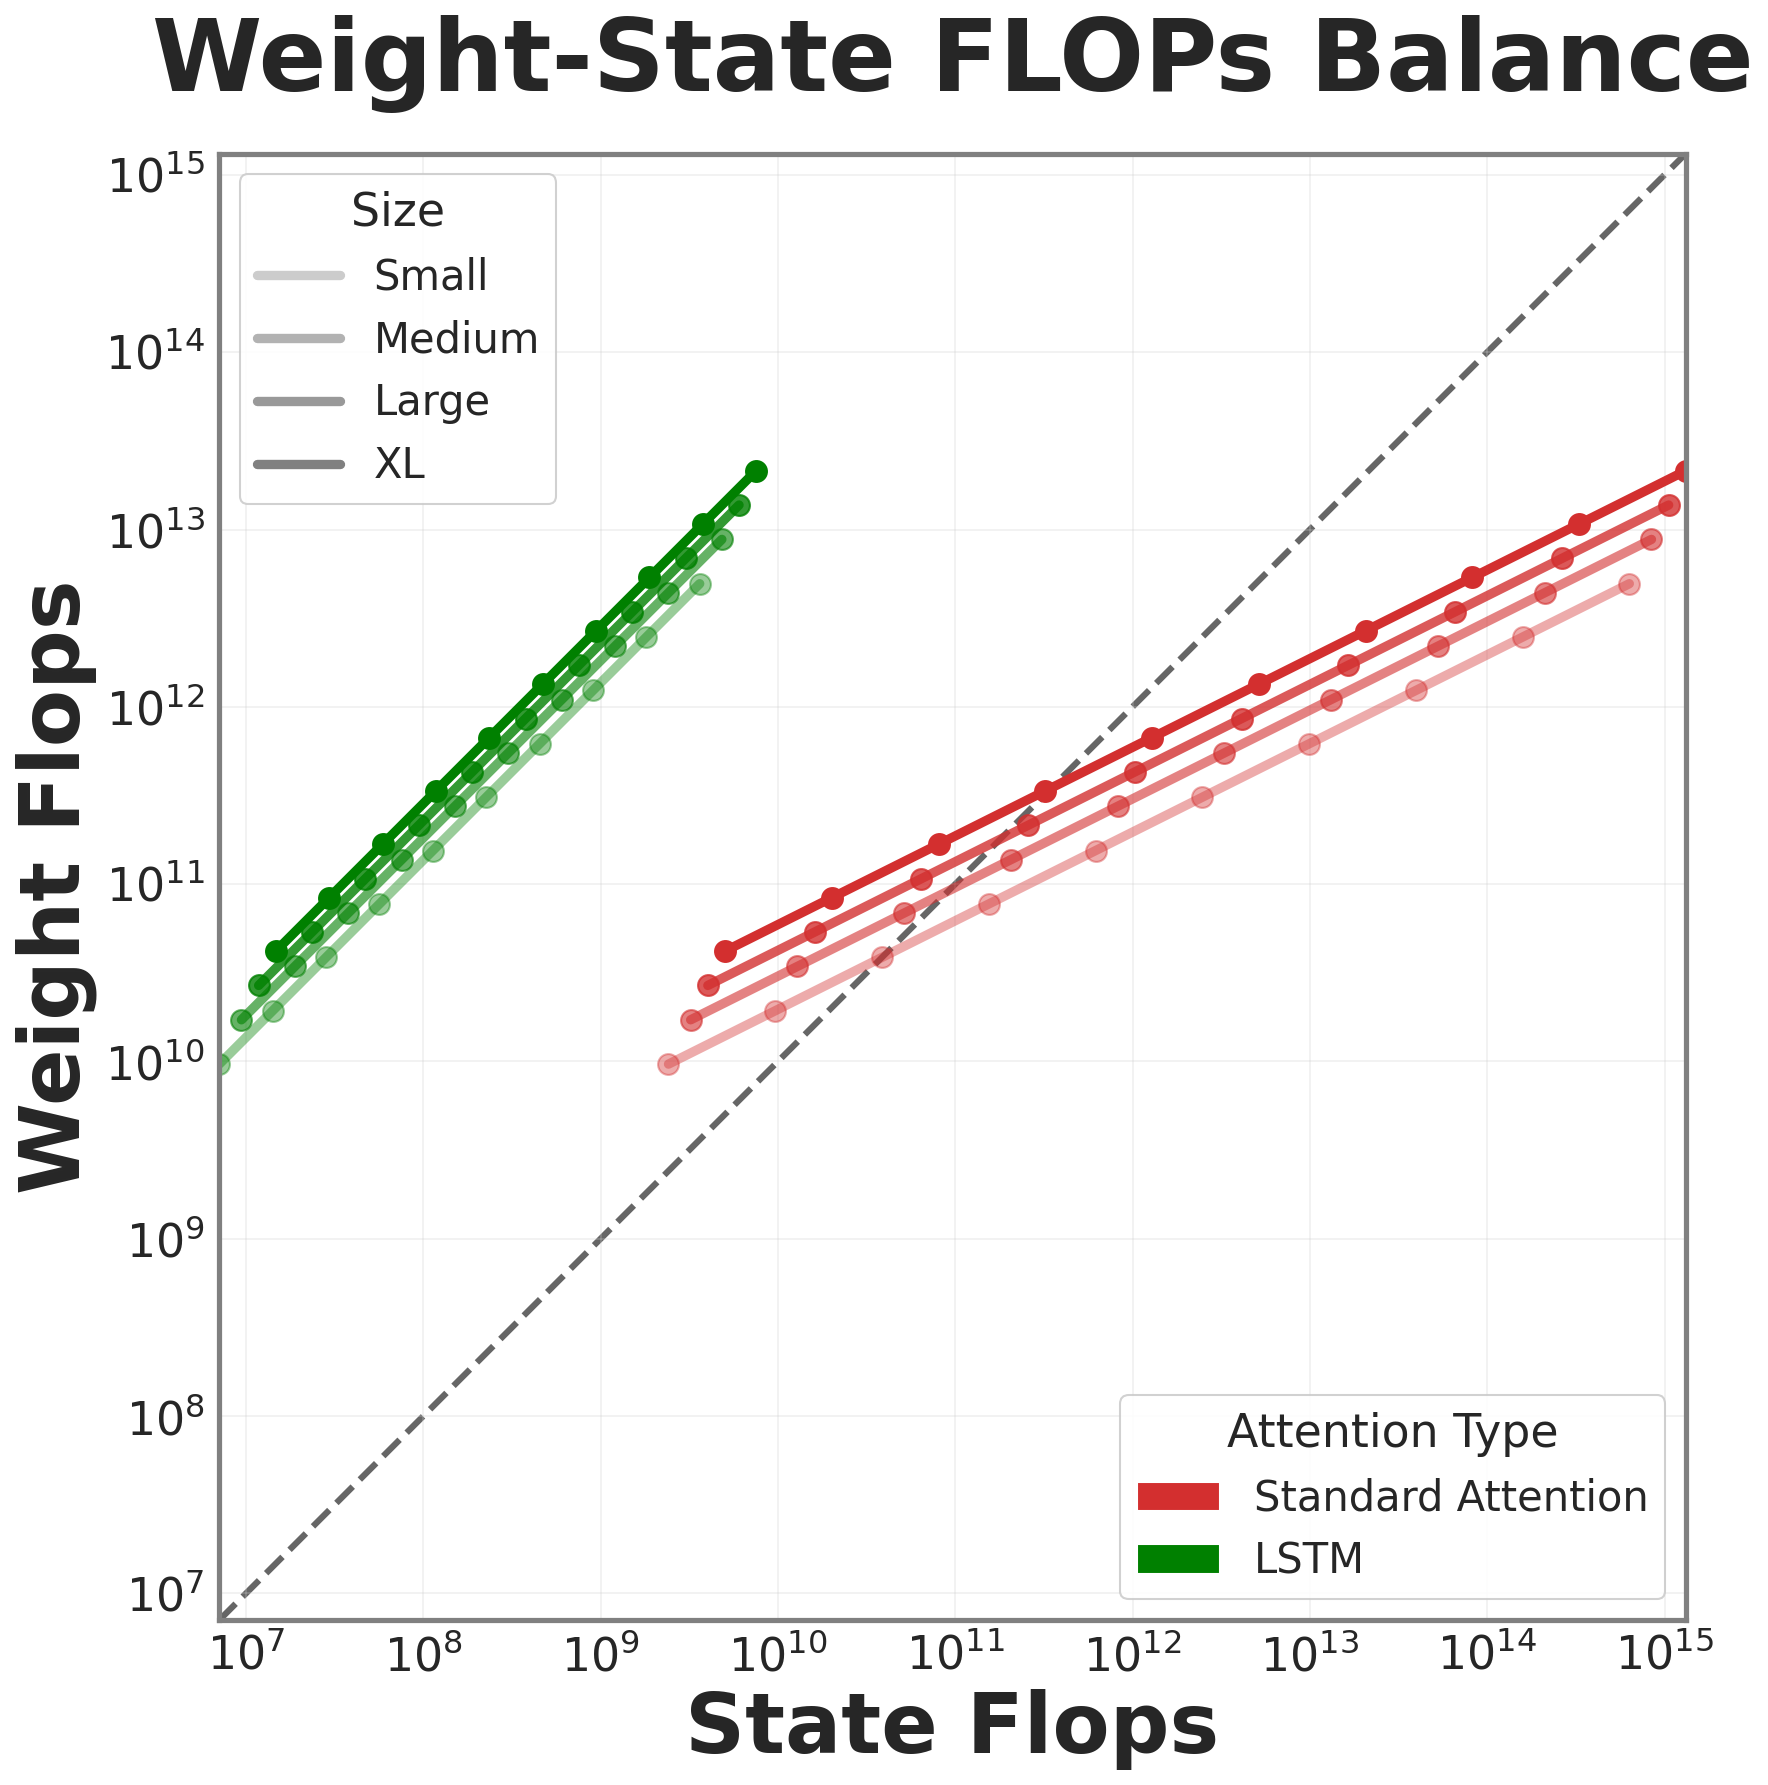

In [24]:
# Set up the plot style for presentation
plt.style.use('default')
sns.set_style("whitegrid")

# Updated: larger figure, higher DPI, better visibility
fig, ax = plt.subplots(figsize=(14, 12), dpi=150)

# Updated: larger markers and thicker lines
for model in df['model'].unique():
    if 'linear' in model or 'power' in model or 'mamba' in model: continue
    model_data = df[df['model'] == model]
    attention_type = model_data['attention'].iloc[0]
    
    if 'small' in model:
        size = 'small'
    elif 'medium' in model:
        size = 'medium'
    elif 'large' in model:
        size = 'large'
    else:
        size = 'xl'
    
    alpha = size_alphas[size]
    
    ax.plot(
        model_data['state_flops'], 
        model_data['weight_flops'],
        marker='o', 
        markersize=10,     # bigger marker
        linewidth=4.5,     # thicker line
        alpha=alpha,
        color=attention_colors[attention_type],
        label=model,
        linestyle='-'
    )

# Updated: thicker and more visible reference line
ax.plot(
    [min_val, max_val], [min_val, max_val], 
    'k--', alpha=0.6, linewidth=3, label='y = x (reference)', zorder=0
)

ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal', adjustable='box')

# Updated: larger title and labels
ax.set_title('Weight-State FLOPs Balance', fontsize=48, fontweight='bold', pad=30)
ax.set_xlabel('State Flops', fontsize=40, fontweight='bold')
ax.set_ylabel('Weight Flops', fontsize=40, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='-')
ax.set_axisbelow(True)

# Updated: bigger legends
model_legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=26, title='Model')
attention_legend = ax.legend(
    handles=[
        Patch(facecolor=attention_colors['attention'], label='Standard Attention'),
        # Patch(facecolor=attention_colors['retention'], label='Power Attention'),
        Patch(facecolor=attention_colors['lstm'], label='LSTM'),
        # Patch(facecolor=attention_colors['mamba'], label='Mamba')
    ],
    loc='lower right',
    title='Attention Type',
    fontsize=20,
    framealpha=0.9
)
attention_legend.set_title('Attention Type', prop={'size': 22})

size_legend = ax.legend(
    handles=[
        Line2D([0], [0], color='gray', linewidth=4.5, alpha=size_alphas['small'], label='Small'),
        Line2D([0], [0], color='gray', linewidth=4.5, alpha=size_alphas['medium'], label='Medium'),
        Line2D([0], [0], color='gray', linewidth=4.5, alpha=size_alphas['large'], label='Large'),
        Line2D([0], [0], color='gray', linewidth=4.5, alpha=size_alphas['xl'], label='XL')
    ],
    loc='upper left',
    title='Size',
    fontsize=20,
    framealpha=0.9
)
size_legend.set_title('Size', prop={'size': 22})

ax.add_artist(model_legend)
ax.add_artist(attention_legend)

# Updated: larger tick labels
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=18)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)
    spine.set_color('gray')

plt.tight_layout()

# Save again
plt.savefig('weight_vs_state_flops_slide.svg', format='svg', dpi=300, bbox_inches='tight')
plt.savefig('weight_vs_state_flops_slide.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


# Generate context - state plot

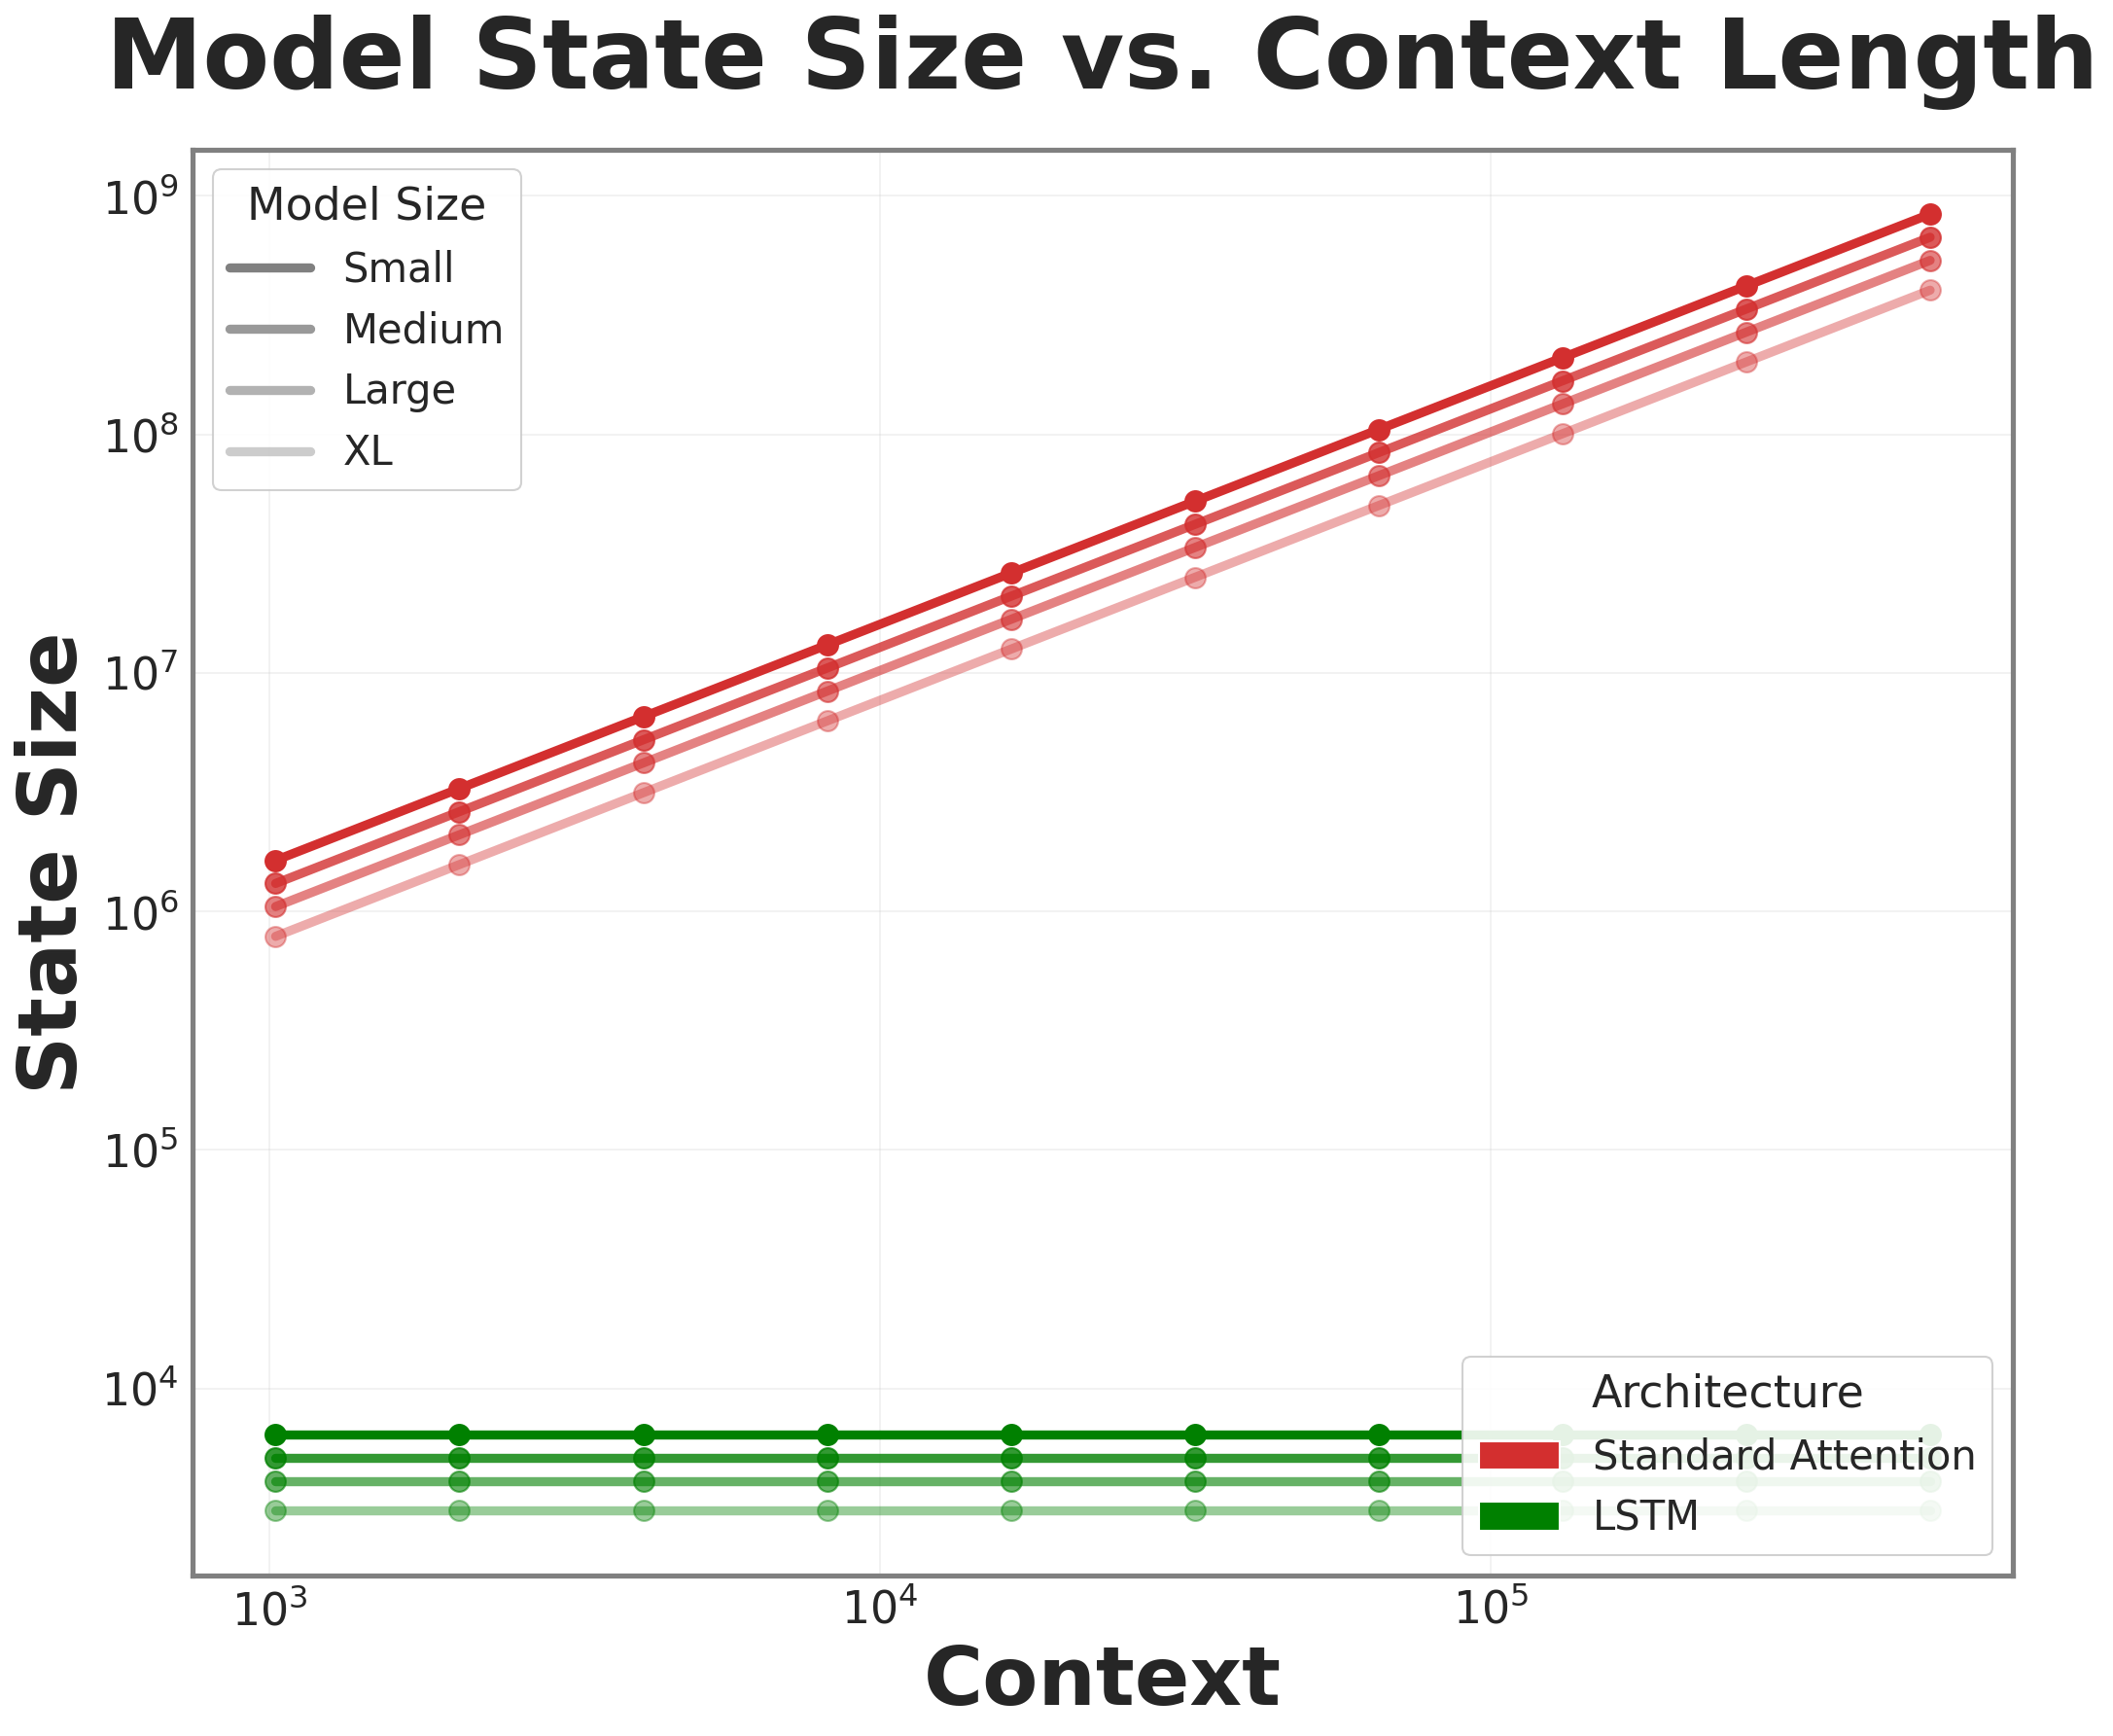

In [28]:
fig, ax = plt.subplots(figsize=(14, 12), dpi=150)

for model in df['model'].unique():
    model_data = df[df['model'] == model]
    attention_type = model_data['attention'].iloc[0]

    if 'small' in model:
        size = 'small'
        alpha = 0.4
    elif 'medium' in model:
        size = 'medium'
        alpha = 0.6
    elif 'large' in model:
        size = 'large'
        alpha = 0.8
    else:
        size = 'xl'
        alpha = 1.0

    ax.plot(
        model_data['context'], 
        model_data['state_size'],
        marker='o',
        markersize=10,
        linewidth=4.5,
        alpha=alpha,
        color=attention_colors[attention_type],
        label=model,
        linestyle='-'
    )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Model State Size vs. Context Length', fontsize=48, fontweight='bold', pad=30)
ax.set_xlabel('Context', fontsize=40, fontweight='bold')
ax.set_ylabel('State Size', fontsize=40, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='-')
ax.set_axisbelow(True)

model_legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=26, title='Model')
attention_legend = ax.legend(
    handles=[
        Patch(facecolor=attention_colors['attention'], label='Standard Attention'),
        Patch(facecolor=attention_colors['lstm'], label='LSTM')
    ],
    loc='lower right',
    title='Architecture',
    fontsize=20,
    framealpha=0.9
)
attention_legend.set_title('Architecture', prop={'size': 22})

size_legend = ax.legend(
    handles=[
        Line2D([0], [0], color='gray', linewidth=4.5, alpha=size_alphas['small'], label='Small'),
        Line2D([0], [0], color='gray', linewidth=4.5, alpha=size_alphas['medium'], label='Medium'),
        Line2D([0], [0], color='gray', linewidth=4.5, alpha=size_alphas['large'], label='Large'),
        Line2D([0], [0], color='gray', linewidth=4.5, alpha=size_alphas['xl'], label='XL')
    ],
    loc='upper left',
    title='Model Size',
    fontsize=20,
    framealpha=0.9
)
size_legend.set_title('Model Size', prop={'size': 22})

ax.add_artist(model_legend)
ax.add_artist(attention_legend)

ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=18)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)
    spine.set_color('gray')

plt.tight_layout()
plt.savefig('state_vs_context_slide.svg', format='svg', dpi=300, bbox_inches='tight')
plt.savefig('state_vs_context_slide.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
